<a href="https://colab.research.google.com/github/NishilTayal/Distracted_Driver_Detection/blob/main/Driver_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **State Farm Distracted Driver Detection Project**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## **1. Obtaining and Organizing the Dataset**

### **1.1. Download Dataset from kaggle**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip

### **1.2. Data Visualization**

In [ ]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


<AxesSubplot:xlabel='classname', ylabel='count'>

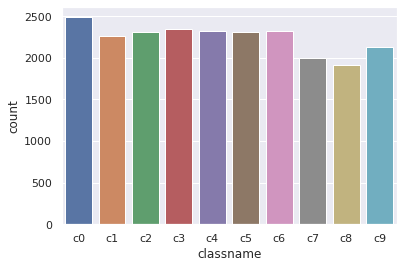

In [ ]:
import seaborn as sns

# Number of images by category
sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

###**1.3. Organizing the Dataset**

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

data_dir = '/content/imgs/train'
splitfolders.ratio(data_dir, output="train_split", ratio=(0.8, 0.1, 0.1))
output_dir = '/content/train_split'

Copying files: 22424 files [00:25, 874.30 files/s] 


## **2. Image Augmentation**

In [ ]:
# Calculate means and stds of the trainset and normalize

train_data = torchvision.datasets.ImageFolder(root = output_dir+'/train', transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3143, 0.3804, 0.3731])
Calculated stds: tensor([0.2874, 0.3307, 0.3320])


In [ ]:
data_augmentation = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        #transforms.Normalize(mean = means, std = stds),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        #transforms.Normalize(mean = means, std = stds),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'cust_test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

## **3. Reading the Dataset**

In [ ]:
Batch_Size = 16
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(output_dir, x),
                                                      data_augmentation[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True,
                                              drop_last=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###**3.1. Images from Original Data**

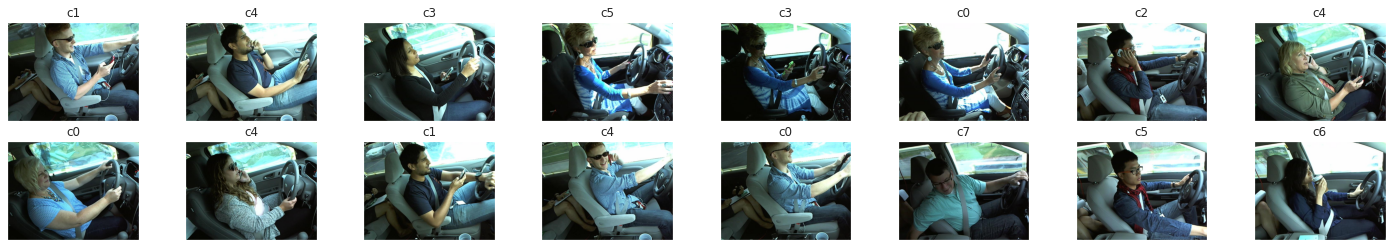

In [ ]:
# Visualize some sample data from the original dataset

images, labels = next(iter(dataloaders['test']))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow((np.transpose(images[idx], (1, 2, 0))))
    ax.set_title(class_names[labels[idx]])

###**3.2. Images after Augmentation**

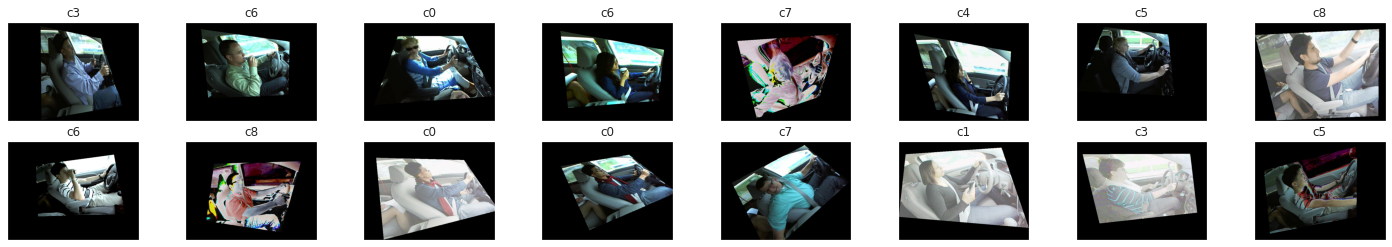

In [ ]:
# Visualize some sample data after Augmentation

images, labels = next(iter(dataloaders['train']))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow((np.transpose(images[idx], (1, 2, 0))))
    ax.set_title(class_names[labels[idx]])

## **4. Defining Models**

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **4.1. DenseNet**

In [ ]:
from torchinfo import summary

Dense = torchvision.models.densenet121(weights='DEFAULT').to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in Dense.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
Dense.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024,
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(Dense,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                       [16, 3, 224, 224]    [16, 1024, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (norm0)                    [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [16, 64, 56, 56]     [16, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [16, 64, 56, 56]     [16, 32, 56, 

In [ ]:
## Model inItialization
criterion_Dense = nn.CrossEntropyLoss()
optimizer_Dense = optim.SGD(Dense.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler_Dense = lr_scheduler.StepLR(optimizer_Dense, step_size=7, gamma=0.1)

###**4.2. EfficientNet B0**

In [ ]:
from torchinfo import summary

EfficientNet_B0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
EfficientNet_B0 = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_weights).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in EfficientNet_B0.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
EfficientNet_B0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(EfficientNet_B0,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 

In [ ]:
## Model inItialization
criterion_EfficientNet_B0 = nn.CrossEntropyLoss()
optimizer_EfficientNet_B0 = optim.SGD(EfficientNet_B0.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler_EfficientNet_B0 = lr_scheduler.StepLR(optimizer_EfficientNet_B0, step_size=7, gamma=0.1)

### **4.3. MobileNet V3**

In [ ]:
from torchinfo import summary

MobileNet_V3 = torchvision.models.mobilenet_v3_large(weights='DEFAULT').to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in MobileNet_V3.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
MobileNet_V3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=960,
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(MobileNet_V3,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 

In [ ]:
## Model inItialization
criterion_MobileNet_V3 = nn.CrossEntropyLoss()
optimizer_MobileNet_V3 = optim.SGD(MobileNet_V3.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler_MobileNet_V3 = lr_scheduler.StepLR(optimizer_MobileNet_V3, step_size=7, gamma=0.1)

## **5. Training Models**

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
def train_model(args):
    """
    Train the Neural Networks
    Args:
        args, dictionary containing all the arguments used in training
            args.model: class name of the model
            args.num_epochs(int): number of epochs
            args.batch_size(int): batch size
            args.criterion: criterion used in training
            args.optimizer: optimizer used in training
            args.scheduler: scheduler used in training
            args.save_checkpoints(bool): save checkpoints
            args.experiment_name(str): experiment name, used as folder name
        net, neural net to be trained
    Return:
        The best neural net in the training
    """
    start_time = time.time()

    save_dir = "output/" + args.experiment_name + "/"

    # if path does not exist, create one
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    best_weight = copy.deepcopy(args.model.state_dict())
    best_acc = 0.0

    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(args.num_epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch}/{args.num_epochs - 1}', end=': ')

        for phase in ['train', 'val']:
            if phase == 'train':
                args.model.train() # training mode
            else:
                args.model.eval()  # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                args.optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = args.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = args.criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        args.optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} loss: {epoch_loss:.4f} {phase} acc: {epoch_acc:.4f}', end=', ')

            if phase == 'train':
                args.scheduler.step()
                train_accs.append(epoch_acc.cpu().detach())
                train_losses.append(epoch_loss)
            else:
                val_accs.append(epoch_acc.cpu().detach())
                val_losses.append(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(args.model.state_dict())

            # save checkpoints every epoch
            if args.save_checkpoints:
                checkpoints_dir = save_dir + f"model_{args.experiment_name}_bs_{args.batch_size}_epoch_{epoch}"
                torch.save(args.model.state_dict(), checkpoints_dir)

        epoch_dur = round(time.time() - epoch_start,2)
        print(f'Epoch time:  {epoch_dur // 60:.0f}m {epoch_dur % 60:.0f}s')

    time_elapsed = time.time() - start_time
    print()
    print('-' * 20)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # save accuracy and loss
    if args.save_checkpoints:
        np.savetxt(save_dir + f"model_{args.experiment_name}_train_acc.csv", train_accs)
        np.savetxt(save_dir + f"model_{args.experiment_name}_train_loss.csv", train_losses)
        np.savetxt(save_dir + f"model_{args.experiment_name}_val_acc.csv", val_accs)
        np.savetxt(save_dir + f"model_{args.experiment_name}_val_loss.csv", val_losses)

    # plot traininng curve
    train_accs, val_accs = np.array(train_accs), np.array(val_accs)
    train_losses, val_losses = np.array(train_losses), np.array(val_losses)

    plt.plot(np.arange(args.num_epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(args.num_epochs, step=1), train_accs, label='Train acc')
    plt.plot(np.arange(args.num_epochs, step=1), val_accs, label='Val acc')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # load and save the best model weights
    checkpoints_dir = save_dir + f"model_{args.experiment_name}_bs_{args.batch_size}_best_model"
    torch.save(args.model.state_dict(best_model_wts), checkpoints_dir)
    args.model.load_state_dict(best_model_wts)

    return args.model

### **5.1. DenseNet**

Epoch 0/4: train loss: 0.6986 train acc: 0.7629, val loss: 0.2699 val acc: 0.9101, Epoch time:  27m 8s
Epoch 1/4: train loss: 0.2216 train acc: 0.9306, val loss: 0.2088 val acc: 0.9356, Epoch time:  27m 8s
Epoch 2/4: train loss: 0.1403 train acc: 0.9583, val loss: 0.2461 val acc: 0.9204, Epoch time:  27m 9s
Epoch 3/4: train loss: 0.1056 train acc: 0.9677, val loss: 0.0827 val acc: 0.9687, Epoch time:  27m 10s
Epoch 4/4: train loss: 0.0950 train acc: 0.9702, val loss: 0.0731 val acc: 0.9665, Epoch time:  27m 10s

--------------------
Training complete in 135m 46s
Best val Acc: 0.968708


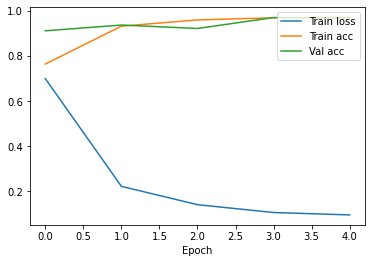

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
Dense_args = AttrDict()

## Args setting
Dense_args_dict = {
    'model': Dense,
    'num_epochs': 5,
    'batch_size': 16,
    'criterion': criterion_Dense,
    'optimizer': optimizer_Dense,
    'scheduler': exp_lr_scheduler_Dense,
    'save_checkpoints': True,
    'experiment_name': "Dense"
}

## Training process
Dense_args.update(Dense_args_dict)
Dense_output_model = train_model(Dense_args)

### **5.2. EfficientNet B0**

Epoch 0/4: train loss: 0.7727 train acc: 0.7403, val loss: 0.1628 val acc: 0.9414, Epoch time:  17m 15s
Epoch 1/4: train loss: 0.1580 train acc: 0.9489, val loss: 0.0787 val acc: 0.9696, Epoch time:  17m 2s
Epoch 2/4: train loss: 0.1058 train acc: 0.9672, val loss: 0.0529 val acc: 0.9790, Epoch time:  17m 2s
Epoch 3/4: train loss: 0.0709 train acc: 0.9775, val loss: 0.0511 val acc: 0.9750, Epoch time:  17m 3s
Epoch 4/4: train loss: 0.0620 train acc: 0.9802, val loss: 0.0280 val acc: 0.9866, Epoch time:  16m 59s

--------------------
Training complete in 85m 22s
Best val Acc: 0.986589


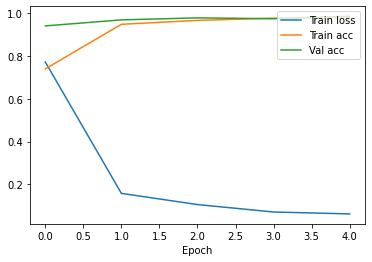

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
EfficientNet_B0_args = AttrDict()

## Args setting
EfficientNet_B0_args_dict = {
    'model': EfficientNet_B0,
    'num_epochs': 5,
    'batch_size': 16,
    'criterion': criterion_EfficientNet_B0,
    'optimizer': optimizer_EfficientNet_B0,
    'scheduler': exp_lr_scheduler_EfficientNet_B0,
    'save_checkpoints': True,
    'experiment_name': "EfficientNet_B0"
}

## Training process
EfficientNet_B0_args.update(EfficientNet_B0_args_dict)
EfficientNet_B0_output_model = train_model(EfficientNet_B0_args)

###**5.3. MobileNet V3**

Epoch 0/4: train loss: 1.0261 train acc: 0.6386, val loss: 0.5383 val acc: 0.8207, Epoch time:  13m 19s
Epoch 1/4: train loss: 0.1956 train acc: 0.9374, val loss: 0.2144 val acc: 0.9267, Epoch time:  13m 15s
Epoch 2/4: train loss: 0.1138 train acc: 0.9649, val loss: 0.1665 val acc: 0.9401, Epoch time:  13m 3s
Epoch 3/4: train loss: 0.0855 train acc: 0.9736, val loss: 0.1346 val acc: 0.9526, Epoch time:  13m 6s
Epoch 4/4: train loss: 0.0666 train acc: 0.9803, val loss: 0.0646 val acc: 0.9736, Epoch time:  13m 3s

--------------------
Training complete in 65m 47s
Best val Acc: 0.973625


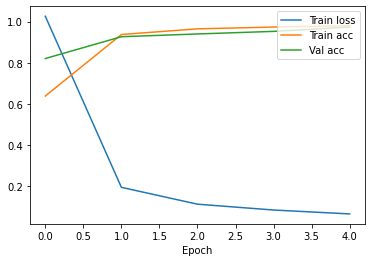

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
MobileNet_V3_args = AttrDict()

## Args setting
MobileNet_V3_args_dict = {
    'model': MobileNet_V3,
    'num_epochs': 5,
    'batch_size': 16,
    'criterion': criterion_MobileNet_V3,
    'optimizer': optimizer_MobileNet_V3,
    'scheduler': exp_lr_scheduler_MobileNet_V3,
    'save_checkpoints': True,
    'experiment_name': "MobileNet_V3"
}

## Training process
MobileNet_V3_args.update(MobileNet_V3_args_dict)
MobileNet_V3_output_model = train_model(MobileNet_V3_args)

## **6. Evaluation on Testset**

### **6.1. Test Accuracy**

In [ ]:
def evaluate_model(model, loader, size):
    """
    Evaluate model performance on testset
    """
    model.eval()
    model.to(device)

    test_acc = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        test_acc += torch.sum(preds == labels.data).item()

    test_acc = test_acc / size

    return test_acc

In [ ]:
Dense_model_state = torch.load('/content/model_Dense_bs_16_best_model')
Dense.load_state_dict(Dense_model_state)
Dense_acc = evaluate_model(Dense, dataloaders['test'], dataset_sizes['test'])
print('Test acc: ', Dense_acc)

Test acc:  0.8996893031513538


In [ ]:
EfficientNet_B0_model_state = torch.load('/content/model_EfficientNet_B0_bs_16_best_model')
EfficientNet_B0.load_state_dict(EfficientNet_B0_model_state)
EfficientNet_B0_acc = evaluate_model(EfficientNet_B0, dataloaders['test'], dataset_sizes['test'])
print('Test acc: ', EfficientNet_B0_acc)

Test acc:  0.9684864624944518


In [ ]:
MobileNet_V3_model_state = torch.load('/content/model_MobileNet_V3_bs_16_best_model')
MobileNet_V3.load_state_dict(MobileNet_V3_model_state)
MobileNet_V3_acc = evaluate_model(MobileNet_V3, dataloaders['test'], dataset_sizes['test'])
print('Test acc: ', MobileNet_V3_acc)

Test acc:  0.9467376830892144
